In [1]:
import os
import pandas as pd
import numpy as np
import time
import pickle

import IPython.display as ipd
import librosa
import librosa.display

from glob import glob
from dotenv import load_dotenv
from my_functions.my_fun import *

In [2]:
load_dotenv()
ANOTATIONS_DIR = os.getenv('PMEMO_ANOTATIONS')
stat_anot = os.path.join(ANOTATIONS_DIR,'static_annotations.csv')
AUDIOS_DIR = os.getenv('PMEMO_AUDIO')
META_DIR = os.getenv('PMEMO_META')
aux_dir = META_DIR.split('.')[0]
META_DIR = f'{aux_dir}_total.csv'
ASSETS_DIR = os.getenv('ASSETS_DIR')


In [3]:
if not os.path.exists(stat_anot):
    print('El archivo de anotaciones no existe')
if not os.path.exists(AUDIOS_DIR):
    print('El directorio de audios no existen')
if not os.path.exists(META_DIR):
    print('El archivo de metadatos no existe')
if not os.path.exists(ASSETS_DIR):
    print('El directorio de assets no existe')

# Información de las canciones

In [4]:
pmemo_df = pd.read_csv(META_DIR)
pmemo_df.head(5)

musicId fileName                   title               artist  \
0        1    1.mp3              Good Drank             2 Chainz   
1        4    4.mp3  X Bitch (feat. Future)            21 Savage   
2        5    5.mp3                No Heart            21 Savage   
3        6    6.mp3                Red Opps            21 Savage   
4        7    7.mp3         Girls Talk Boys  5 Seconds Of Summer   

                                               album  duration  \
0           Def Jam Presents: Direct Deposit, Vol. 2     32.10   
1                                        Savage Mode     28.09   
2                                        Savage Mode     84.23   
3                                           Red Opps     29.53   
4  Ghostbusters (Original Motion Picture Soundtrack)     29.11   

  chorus_start_time chorus_end_time  
0             02:35           03:05  
1             03:00           03:26  
2             00:41           02:03  
3             02:16           02:44  
4             02:30           02:57

# Cargar anotaciones

In [5]:
anot_df = pd.read_csv(stat_anot)
anot_df.head(5)

musicId  Arousal(mean)  Valence(mean)
0        1         0.4000         0.5750
1        4         0.2625         0.2875
2        5         0.1500         0.2000
3        6         0.5125         0.3500
4        7         0.7000         0.7250

# Cargar los audios

In [6]:
audio_list = pmemo_df['fileName'].values
print(audio_list.shape)

audio_files = glob(f'{AUDIOS_DIR}\\*.mp3')
print(len(audio_files))

(767,)
794


In [7]:
i = 0
_audio_files = []
for audio in audio_files:
    aux = audio.split('\\')[-1]
    if aux in audio_list:
        _audio_files.append(audio)
audio_files = _audio_files

print(len(audio_files))
print(len(audio_list))
print(len(anot_df))

767
767
767


ordenar los archivos

In [8]:
audio_files = np.array(audio_files)
sorted_idx = np.argsort([int(os.path.basename(x).split('.')[0]) for x in audio_files])
audio_files = audio_files[sorted_idx]
rdn_idx = np.random.randint(len(audio_list))

print(audio_list[rdn_idx])
print(os.path.basename(audio_files[rdn_idx]))

216.mp3
216.mp3


In [9]:
pmemo_df.loc[rdn_idx]

musicId                              216
fileName                         216.mp3
title                Different for Girls
artist                    Dierks Bentley
album                              Black
duration                           30.11
chorus_start_time                  02:22
chorus_end_time                    02:50
Name: 172, dtype: object

In [10]:
anot_df.loc[rdn_idx]

musicId          216.0000
Arousal(mean)      0.6500
Valence(mean)      0.6625
Name: 172, dtype: float64

# Muestreo aletorio

In [11]:
aux_meta = pmemo_df.loc[pmemo_df['fileName'] == audio_list[rdn_idx]]
display(aux_meta)

musicId fileName                title          artist  album  duration  \
172      216  216.mp3  Different for Girls  Dierks Bentley  Black     30.11   

    chorus_start_time chorus_end_time  
172             02:22           02:50

In [12]:
ipd.Audio(audio_files[rdn_idx])

In [13]:
y,sr = librosa.load(audio_files[rdn_idx],offset=0,duration=38)
print(f'y:{y[:25]}')
print(f'shape y: {y.shape}')
print(f'sr:{sr}')

y:[ 3.4106051e-13 -1.7053026e-13 -6.2527761e-13  4.5474735e-13
 -2.2737368e-13  4.5474735e-13 -2.8421709e-14 -5.1159077e-13
 -5.2580162e-13 -3.9790393e-13 -5.6843419e-14  6.2527761e-13
  1.5063506e-12 -2.8421709e-14 -5.1159077e-13 -7.9580786e-13
  5.1159077e-13  1.7053026e-13  7.6738615e-13 -2.2737368e-13
 -1.1368684e-13 -2.2737368e-13  7.1054274e-14  6.8212103e-13
  2.2737368e-13]
shape y: (662400,)
sr:22050


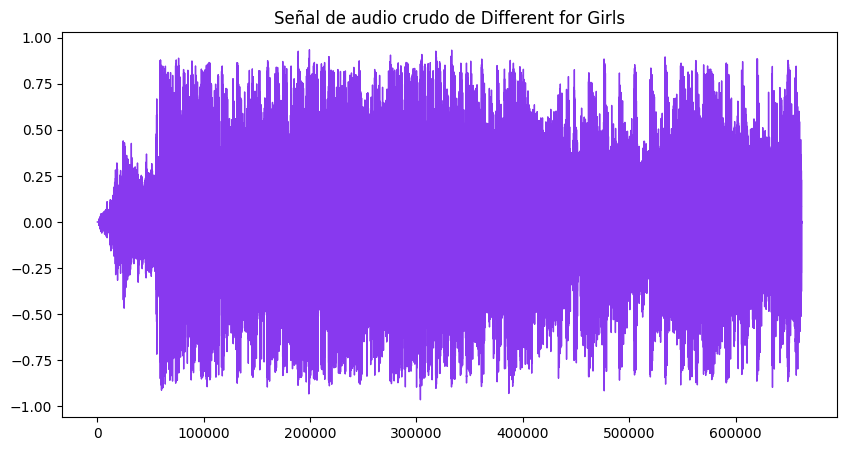

In [14]:
_title = f"Señal de audio crudo de {aux_meta['title'].values[0]}"
show_audio_signal(y,_title)

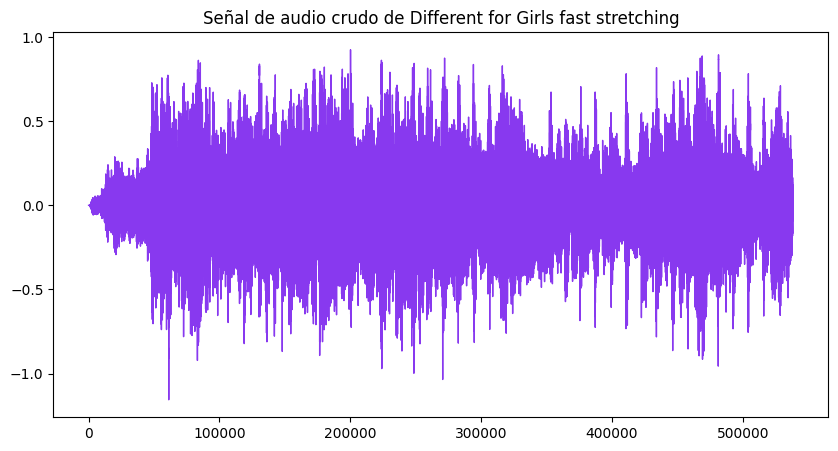

In [15]:
y_fast = librosa.effects.time_stretch(y,rate=1.23)
yf_title =f'{ _title} fast stretching'
show_audio_signal(y_fast,yf_title)
ipd.Audio(y_fast,rate=sr)

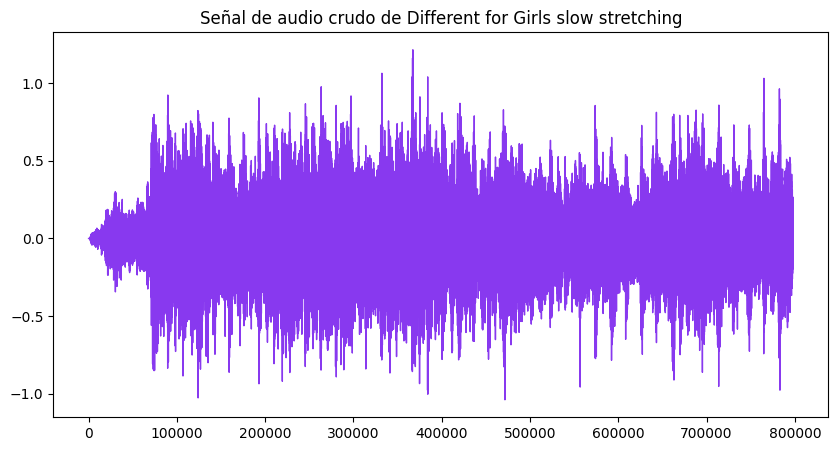

In [16]:
y_slow = librosa.effects.time_stretch(y,rate=0.83)
ys_title =f'{ _title} slow stretching'
show_audio_signal(y_slow,ys_title)
ipd.Audio(y_slow,rate=sr)

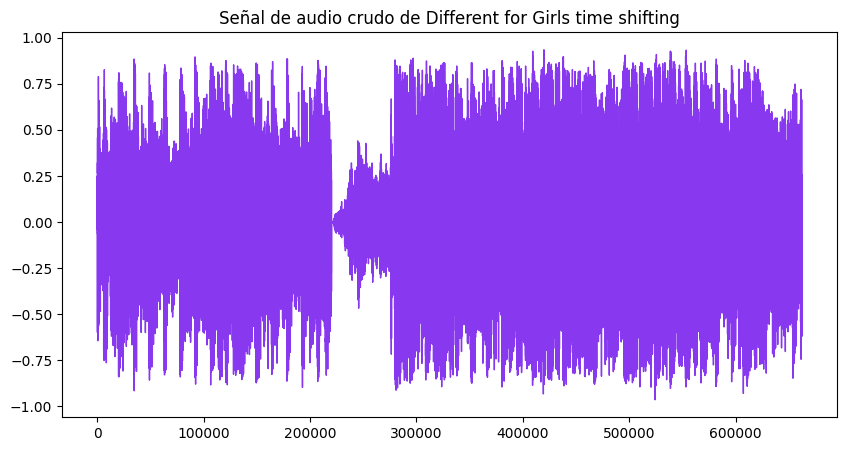

In [17]:
tsh = 10
y_sh = np.roll(y,tsh*sr)
ysh_title = f'{ _title} time shifting'
show_audio_signal(y_sh,ysh_title)
ipd.Audio(y_sh,rate=sr)

In [18]:
print(len(y))
print(len(y_fast))
print(len(y_slow))

662400
538537
798072


# Aumento de datos

In [19]:
anot_df = anot_df.rename(columns={'Arousal(mean)':'Arousal',
                             'Valence(mean)':'Valence'})
anot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   musicId  767 non-null    int64  
 1   Arousal  767 non-null    float64
 2   Valence  767 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 18.1 KB


In [20]:
start_time = time.time()

augmented_df = data_augmentation(audio_files,anot_df,38)

end_time = time.time()
elapsed_time = end_time - start_time


display(augmented_df)

Tiempo que demoro aumentar 767 audios


musicId  Arousal(mean)  Valence(mean)  isAugmented  \
0         1.0         0.4000          0.575        False   
1         1.0         0.4000          0.575         True   
2         1.0         0.4000          0.575         True   
3         1.0         0.4000          0.575         True   
4         1.0         0.4000          0.575         True   
...       ...            ...            ...          ...   
4597   1000.0         0.6625          0.575         True   
4598   1000.0         0.6625          0.575         True   
4599   1000.0         0.6625          0.575         True   
4600   1000.0         0.6625          0.575         True   
4601   1000.0         0.6625          0.575         True   

                              info  \
0                      Source file   
1     Time stretching 0.81 seconds   
2     Time stretching 0.93 seconds   
3     Time stretching 1.07 seconds   
4     Time stretching 1.23 seconds   
...                            ...   
4597  Time stretching 0.81 seconds   
4598  Time stretching 0.93 seconds   
4599  Time stretching 1.07 seconds   
4600  Time stretching 1.23 seconds   
4601       Time shifting 5 seconds   

                                               audioDir  
0     E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...  
1     E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...  
2     E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...  
3     E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...  
4     E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...  
...                                                 ...  
4597  E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...  
4598  E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...  
4599  E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...  
4600  E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...  
4601  E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...  

[4602 rows x 6 columns]

In [22]:
print(f'Tiempo que demoro aumentar {len(audio_files)} audios: {elapsed_time /60} minutos')

Tiempo que demoro aumentar 767 audios: 21.327527832984924 minutos


In [28]:
augmented_anotations = os.path.join(ANOTATIONS_DIR,'agumented.csv')
augmented_df.to_csv(augmented_anotations)